In [34]:
%matplotlib inline
import numpy as np
import pandas as pd 
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nibabel as nb
from skimage import measure
import re
from argparse import ArgumentParser

import torch
import torch.nn as nn
from pytorch_lightning import seed_everything
import pickle

from lightning import getModules

from umap import UMAP
import matplotlib
from utils import yaml
from sklearn.manifold import TSNE
import seaborn as sns

from logging import logMultiprocessing
from typing import Tuple
import torch
from pytorch_lightning import Trainer
import DataModule
import Models
from Training import TrainFactorySVDD
from lightning import getModulesSVDD

In [ ]:
seed_everything(42, workers=True)

config = '../../configs/AE_LeNet_bothHippocampiFlip_lr_001_rd_32_MSE_16filtersSVDDDifferenceVolume.yml'
checkpoint = '../results/AE_LeNet_bothHippocampiFlip_lr_001_rd_32_MSE_16filtersSVDDDifferenceVolume/version_0/checkpoints/last.ckpt'

fast_dev_run=False
accelerator="gpu"

config_name = os.path.basename(config)
config_name = re.sub(r'.ya?ml$', '', config_name)
config = {'name': config_name, **yaml.load(config)}

trainerSVDD, modelTrainerSVDD, dataModuleSVDD = getModulesSVDD(config, fast_dev_run, accelerator,pretrained=False)
results = trainerSVDD.predict(modelTrainerSVDD, dataModuleSVDD, ckpt_path=checkpoint) # train the model  

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Setting up a new session...


...................................datafactory.init
...................................getpipe.datafactory
...............................................getfilter UnPack
...............................................getfilter Pack
...............................................getfilter ApplyOne
...................................getpipe.datafactory
...............................................getfilter npFunction
...............................................getfilter ApplyOne
...................................getpipe.datafactory
...............................................getfilter npFunction
...................................datafactory.init
...............................................getfdatasetr MultiDataset
...................................getpipe.datafactory
...............................................getfdatasetr Dataset
...................................getpipe.datafactory
...............................................getfilter LoadFlipImagePairDifferenceVo

Restoring states from the checkpoint path at ../results/AE_LeNet_bothHippocampiFlip_lr_001_rd_32_MSE_16filtersSVDDDifferenceVolume/version_0/checkpoints/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../results/AE_LeNet_bothHippocampiFlip_lr_001_rd_32_MSE_16filtersSVDDDifferenceVolume/version_0/checkpoints/last.ckpt


Predicting DataLoader 0:   0%|                          | 0/106 [00:00<?, ?it/s]wait a few seconds, initializing center


In [28]:
trainedModel = trainerSVDD.model._model.to('cuda')

In [29]:
testdata = dataModuleSVDD._test_data
filenames = testdata.filenames

def tensor_from_list (lista):
    outputs, right_v, left_v = [],[],[]
    for i in lista:
        raw_image = testdata.get(i)[0][0]
        raw_image_unsqueeze = torch.unsqueeze(raw_image,0)
        outputs.append(raw_image_unsqueeze)
        right_v.append(testdata.get(i)[0][1])
        left_v.append(testdata.get(i)[0][2]) 
        
    return torch.cat(outputs, dim=0).cpu(),torch.from_numpy(np.array(right_v)), torch.from_numpy(np.array(left_v))

In [30]:
SYNTHETIC_S1 = tensor_from_list(['S1_r_ROFFO_GC_P20left','S1_r_ROFFO_GC_P21left',
                                 'S1_r_ROFFO_GC_P22left','S1_r_ROFFO_GC_P23left','S1_r_ROFFO_GC_P24left','S1_r_ROFFO_GC_P25left',
                                 'S1_r_ROFFO_GC_P26left','S1_r_ROFFO_GC_P27left','S1_r_ROFFO_GC_P28left','S1_r_ROFFO_GC_P29left',
                                 'S1_r_ROFFO_GC_P30left','S1_r_ROFFO_GC_P50left','S1_r_ROFFO_GC_P51left','S1_r_ROFFO_GC_P52left',
                                 'S1_r_ROFFO_GC_P53left','S1_r_ROFFO_GC_P54left','S1_r_ROFFO_GC_P55left','S1_r_ROFFO_GC_P56left',
                                 'S1_r_ROFFO_GC_P57left','S1_r_ROFFO_GC_P58left','S1_r_ROFFO_GC_P59left','S1_r_ROFFO_GC_P60left'])
SYNTHETIC_S2 = tensor_from_list(['S2_r_ROFFO_GC_P20left','S2_r_ROFFO_GC_P21left',
                                 'S2_r_ROFFO_GC_P22left','S2_r_ROFFO_GC_P23left','S2_r_ROFFO_GC_P24left','S2_r_ROFFO_GC_P25left',
                                 'S2_r_ROFFO_GC_P26left','S2_r_ROFFO_GC_P27left','S2_r_ROFFO_GC_P28left','S2_r_ROFFO_GC_P29left',
                                 'S2_r_ROFFO_GC_P30left','S2_r_ROFFO_GC_P50left','S2_r_ROFFO_GC_P51left','S2_r_ROFFO_GC_P52left',
                                 'S2_r_ROFFO_GC_P53left','S2_r_ROFFO_GC_P54left','S2_r_ROFFO_GC_P55left','S2_r_ROFFO_GC_P56left',
                                 'S2_r_ROFFO_GC_P57left','S2_r_ROFFO_GC_P58left','S2_r_ROFFO_GC_P59left','S2_r_ROFFO_GC_P60left'])
SYNTHETIC_S3 = tensor_from_list(['S3_r_ROFFO_GC_P20left','S3_r_ROFFO_GC_P21left',
                                 'S3_r_ROFFO_GC_P22left','S3_r_ROFFO_GC_P23left','S3_r_ROFFO_GC_P24left','S3_r_ROFFO_GC_P25left',
                                 'S3_r_ROFFO_GC_P26left','S3_r_ROFFO_GC_P27left','S3_r_ROFFO_GC_P28left','S3_r_ROFFO_GC_P29left',
                                 'S3_r_ROFFO_GC_P30left','S3_r_ROFFO_GC_P50left','S3_r_ROFFO_GC_P51left','S3_r_ROFFO_GC_P52left',
                                 'S3_r_ROFFO_GC_P53left','S3_r_ROFFO_GC_P54left','S3_r_ROFFO_GC_P55left','S3_r_ROFFO_GC_P56left',
                                 'S3_r_ROFFO_GC_P57left','S3_r_ROFFO_GC_P58left','S3_r_ROFFO_GC_P59left','S3_r_ROFFO_GC_P60left'])

SYNTHETIC_S1 = [SYNTHETIC_S1[:][0].to('cuda'),SYNTHETIC_S1[:][1].to('cuda'),SYNTHETIC_S1[:][2].to('cuda')]
SYNTHETIC_S2 = [SYNTHETIC_S2[:][0].to('cuda'),SYNTHETIC_S2[:][1].to('cuda'),SYNTHETIC_S2[:][2].to('cuda')]
SYNTHETIC_S3 = [SYNTHETIC_S3[:][0].to('cuda'),SYNTHETIC_S3[:][1].to('cuda'),SYNTHETIC_S3[:][2].to('cuda')]

synthetic_S1 = trainedModel.predict(SYNTHETIC_S1).cpu().detach().numpy()
synthetic_S2 = trainedModel.predict(SYNTHETIC_S2).cpu().detach().numpy()
synthetic_S3 = trainedModel.predict(SYNTHETIC_S3).cpu().detach().numpy()

synthetic_S1_S2_S3 = torch.cat((torch.from_numpy(synthetic_S1),torch.from_numpy(synthetic_S2),torch.from_numpy(synthetic_S3)), 0).cpu().detach().numpy()


print(synthetic_S1.shape)
print(synthetic_S2.shape)
print(synthetic_S3.shape)
print(synthetic_S1_S2_S3.shape)

(22, 32)
(22, 32)
(22, 32)
(66, 32)


### ADNI

In [31]:
df = pd.read_csv('../../data/ADNICDR.csv')
ADNI_con, ADNI_mci, ADNI_ad = [], [], []
filenames = testdata.filenames

for i in range(len(filenames[51:207])):

    name = filenames[51+i]
    b = df.loc[df['12'] == str(name[2:10])]
    d =np.array(b['2'])

    if d == 'AD':
        ADNI_ad.append(filenames[51+i])

    if d == 'CN':
        ADNI_con.append(filenames[51+i])

    if d == 'MCI':
        ADNI_mci.append(filenames[51+i])

ADNI_con_right, ADNI_mci_right, ADNI_ad_right = ADNI_con, ADNI_mci, ADNI_ad


ADNI_con, ADNI_mci, ADNI_ad = [], [], []
for i in range(len(filenames[490:])):

    name = filenames[490+i]
    b = df.loc[df['12'] == str(name[2:10])]
    d =np.array(b['2'])

    if d == 'AD':
        ADNI_ad.append(filenames[490+i])

    if d == 'CN':
        ADNI_con.append(filenames[490+i])

    if d == 'MCI':
        ADNI_mci.append(filenames[490+i])

ADNI_con_left, ADNI_mci_left, ADNI_ad_left = ADNI_con, ADNI_mci, ADNI_ad

ADNI_con_left = tensor_from_list(ADNI_con_left)
ADNI_mci_left = tensor_from_list(ADNI_mci_left)
ADNI_ad_left = tensor_from_list(ADNI_ad_left)

ADNI_con_right = tensor_from_list(ADNI_con_right)
ADNI_mci_right = tensor_from_list(ADNI_mci_right)
ADNI_ad_right = tensor_from_list(ADNI_ad_right)



/home/duilio/anaconda3/envs/deepsvd/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/duilio/anaconda3/envs/deepsvd/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/duilio/anaconda3/envs/deepsvd/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [7]:
ADNI_con_right = [ADNI_con_right[:][0].to('cuda'),ADNI_con_right[:][1].to('cuda'),ADNI_con_right[:][2].to('cuda')]
ADNI_ad_right = [ADNI_ad_right[:][0].to('cuda'),ADNI_ad_right[:][1].to('cuda'),ADNI_ad_right[:][2].to('cuda')]
ADNI_con = trainedModel.predict(ADNI_con_right).cpu().detach().numpy()
ADNI_ad = trainedModel.predict(ADNI_ad_right).cpu().detach().numpy()
ADNI_mci_right = [ADNI_mci_right[:][0].to('cuda'),ADNI_mci_right[:][1].to('cuda'),ADNI_mci_right[:][2].to('cuda')]
ADNI_mci = trainedModel.predict(ADNI_mci_right).cpu().detach().numpy()

In [8]:
a = torch.from_numpy(ADNI_con)
c = torch.mean(a, 0)

In [9]:
ADNI_mci = torch.sum((torch.from_numpy(ADNI_mci) - c) ** 2, dim=1)

ADNI_con = torch.sum((torch.from_numpy(ADNI_con) - c) ** 2, dim=1).numpy()

ADNI_ad = torch.sum((torch.from_numpy(ADNI_ad) - c) ** 2, dim=1).numpy()

syntheticS1 = torch.sum((torch.from_numpy(synthetic_S1) - c) ** 2, dim=1).numpy()
syntheticS2 = torch.sum((torch.from_numpy(synthetic_S2) - c) ** 2, dim=1).numpy()
syntheticS3 = torch.sum((torch.from_numpy(synthetic_S3) - c) ** 2, dim=1).numpy()

syntheticsynthetic_S1_S2_S3 = torch.sum((torch.from_numpy(synthetic_S1_S2_S3) - c) ** 2, dim=1).numpy()


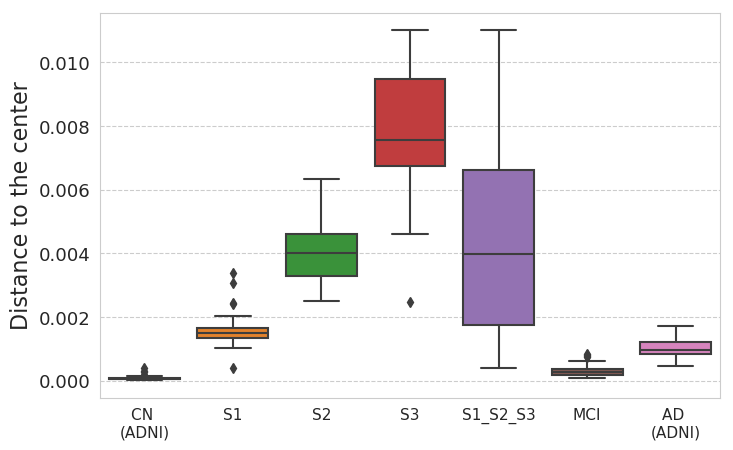

In [13]:
fig = plt.figure(figsize =(10, 4))
ax = fig.add_subplot(111)
fig.set_size_inches(8, 5)


all_arr = [ADNI_con, syntheticS1,syntheticS2,syntheticS3,syntheticsynthetic_S1_S2_S3,
            ADNI_mci,ADNI_ad]

sns.boxplot(data=all_arr)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xticks([ 0, 1, 2, 3, 4, 5,6], ['CN \n(ADNI)','S1','S2','S3','S1_S2_S3','MCI', 'AD \n(ADNI)'], fontsize=11)
plt.yticks(fontsize=13)
ax.set_ylabel('Distance to the center', fontsize=16)  

plt.show()

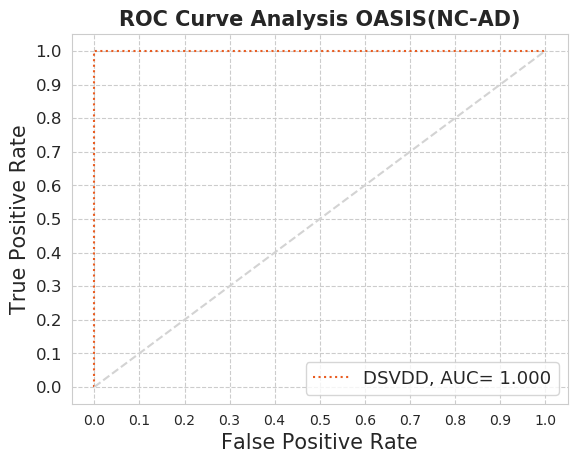

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score

salidas = np.hstack((ADNI_con,ADNI_ad,))
etiquetas = np.concatenate(([0]*len(ADNI_con),[1]*32),axis=0)
auc_AD = roc_auc_score(etiquetas, salidas)
fpr, tpr, thresholds = roc_curve(etiquetas, salidas)

fig = plt.figure()
plt.plot(fpr, tpr, label="DSVDD, AUC= {:.3f}".format(auc_AD), color='#E95C20FF', linestyle=':')
plt.plot([0,1], [0,1], color='lightgray', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=12)
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis OASIS(NC-AD)', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

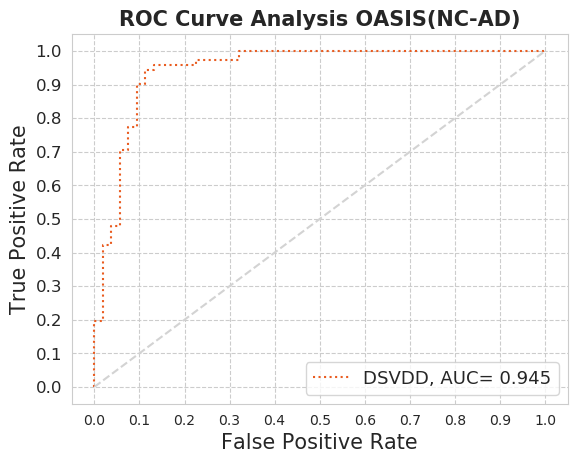

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score

salidas = np.hstack((ADNI_con,ADNI_mci))
etiquetas = np.concatenate(([0]*len(ADNI_con),[1]*len(ADNI_mci)),axis=0)
auc_AD = roc_auc_score(etiquetas, salidas)
fpr, tpr, thresholds = roc_curve(etiquetas, salidas)

fig = plt.figure()
plt.plot(fpr, tpr, label="DSVDD, AUC= {:.3f}".format(auc_AD), color='#E95C20FF', linestyle=':')
plt.plot([0,1], [0,1], color='lightgray', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1), fontsize=12)
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis OASIS(NC-AD)', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()